# Social acceptance of wind and impact on deployment

<br>
<br>
This notebook's purpose is to present a "toy model" for the study of the consequences of contention on wind deployment. The toy model aims at illustrating:

- How a "contention" layer could be computed based on the work from Bessette & Mills and how this adds a new constraint to siting.

- How siting could be optimized to balance the trade-off between contention levels and wind resources across the US,  thereby minimizing delays in wind power development.

*By offering a solution to project and minimize potential delays in wind development, the project will support the CLEAN future act goal of a 100% zero-emission United States (US) electricity grid by 2035.*
<br>
<br>
The state of Illinois is used as a case study for this toy model.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.stats import truncnorm, linregress
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from typing import Type
import random
import statsmodels.formula.api as st_mdl
from math import pi, exp, ceil
import seaborn as sns
import time
%matplotlib inline

## Setting up the environment

In [69]:
# Reads Illinois shape file and create a geopanda data frame
il = gpd.read_file('./ilinois2/2010_Illinois_County_TotalPopulationDensity.shp')
df = pd.DataFrame(il)
geo_df = gpd.GeoDataFrame(df)
geo_df.head()

,TotPopDens,County,State,TotPopNum,AREAsqmi,FIPS_Cnty,geometry
0,37.229000,Jo Daviess,Illinois,22678.0,609.147602,17085,"POLYGON ((-89.92558 42.50751, -89.92466 42.458..."
1,86.183800,Stephenson,Illinois,47711.0,553.595891,17177,"POLYGON ((-89.40308 42.50300, -89.40128 42.463..."
2,573.309998,Winnebago,Illinois,295266.0,515.019710,17201,"POLYGON ((-89.36452 42.50294, -89.31850 42.502..."
3,510.584991,McHenry,Illinois,308760.0,604.717660,17111,"POLYGON ((-88.30162 42.49791, -88.19713 42.498..."
4,194.406006,Boone,Illinois,54165.0,278.618125,17007,"POLYGON ((-88.77372 42.49575, -88.77185 42.495..."


### Compute contention, wind speed, and available land

The model from [Bessette & Mills (2021)](https://doi.org/10.1016/j.erss.2020.101873) is used to compute contention levels across Illinois. Several approximations are made to simplify the toy model.

In [70]:
# Initializes random seed
np.random.seed(0)

def trunc_normal_distrib_draw(
        min_distrib: float, max_distrib: float, mean: float,
        standard_deviation: float) -> float:
    """
    Draw a value from a truncated normal distribution.
    :param min_distrib: minimum of the range from where to draw.
    :param max_distrib: maximum of the range from where to draw.
    :param mean: mean of the distribution.
    :param standard_deviation: standard deviation of the distribution.
    :return: drawn value.
    """
    a = (min_distrib - mean) / standard_deviation
    b = (max_distrib - mean) / standard_deviation
    loc = mean
    scale = standard_deviation
    distribution = truncnorm(a, b, loc, scale)
    draw = float(distribution.rvs(1))
    return draw

# Bessette & Mills approximate data (using truncated normal distribution based on Bessette & Mills summary statistics 
# and not actual data) - https://doi.org/10.1016/j.erss.2020.101873
geo_df['percent_prod'] = np.nan
geo_df['percent_prod'] = geo_df['percent_prod'].apply(lambda x: trunc_normal_distrib_draw(0, 100, 25, 8))
geo_df['percent_rep'] = np.nan
geo_df['percent_rep'] = geo_df['percent_rep'].apply(lambda x: trunc_normal_distrib_draw(0, 100, 63, 7))
geo_df['amenities'] = np.nan
geo_df['amenities'] = geo_df['amenities'].apply(lambda x: trunc_normal_distrib_draw(1, 4, 2.2, 0.72))
geo_df['illinois'] = np.where(df['State'] == 'Illinois', True, False)
intercept = 9.77
percent_prod_beta = -0.145
percent_rep_beta = -0.077
amenity_beta = 1.599
illinois_beta = 2.4

# Bessette & Mills approximate model (only keeping significant independent variables)
geo_df['contention'] = (intercept + percent_prod_beta * geo_df['percent_prod'] + 
                        percent_rep_beta * geo_df['percent_rep'] + amenity_beta * geo_df['amenities'] +
                        illinois_beta * geo_df['illinois'])

# Average wind speed placeholder (m/s) - https://windexchange.energy.gov/maps-data/37
geo_df['wind_speed'] = np.nan
geo_df['wind_speed'] = geo_df['wind_speed'].apply(lambda x: trunc_normal_distrib_draw(4.5, 7.5, 6, 1))

# Maximum of new wind turbines placeholder
# Assumes only 5% of total area is available
# Assumes a new wind plant turbine takes 2/10 of a square mile 
# (https://sciencing.com/much-land-needed-wind-turbines-12304634.html)
land_use_turbine = 2 / 10  # square mile / turbine
geo_df['percent_area_avbl'] = np.nan
geo_df['percent_area_avbl'] = geo_df['percent_area_avbl'].apply(lambda x: trunc_normal_distrib_draw(0, 0.5, 0.025, 0.01))
geo_df['max_n_turbine'] = (geo_df['AREAsqmi'] * geo_df['percent_area_avbl'] / land_use_turbine).astype(int)

# Corrects model results so that contention is between 0 and 10 (as measured by Bessette & Mills' survey)
geo_df['contention'] = np.where(geo_df['contention'] > 10, 10, geo_df['contention'])
geo_df['contention'] = np.where(geo_df['contention'] < 0, 0, geo_df['contention'])

geo_df.head()

,TotPopDens,County,State,TotPopNum,AREAsqmi,FIPS_Cnty,geometry,percent_prod,percent_rep,amenities,illinois,contention,wind_speed,percent_area_avbl,max_n_turbine
0,37.229000,Jo Daviess,Illinois,22678.0,609.147602,17085,"POLYGON ((-89.92558 42.50751, -89.92466 42.458...",25.989419,67.400188,1.143487,True,5.040155,5.090687,0.027972,85
1,86.183800,Stephenson,Illinois,47711.0,553.595891,17177,"POLYGON ((-89.40308 42.50300, -89.40128 42.463...",29.554845,75.436670,1.322268,True,4.190231,4.789772,0.007385,20
2,573.309998,Winnebago,Illinois,295266.0,515.019710,17201,"POLYGON ((-89.36452 42.50294, -89.31850 42.502...",27.091378,58.251069,2.558025,True,7.846699,6.511363,0.004805,12
3,510.584991,McHenry,Illinois,308760.0,604.717660,17111,"POLYGON ((-88.30162 42.49791, -88.19713 42.498...",25.910117,64.344508,2.158445,True,6.909859,4.572430,0.023296,70
4,194.406006,Boone,Illinois,54165.0,278.618125,17007,"POLYGON ((-88.77372 42.49575, -88.77185 42.495...",23.470047,64.629605,2.300297,True,7.468539,6.626258,0.010524,14


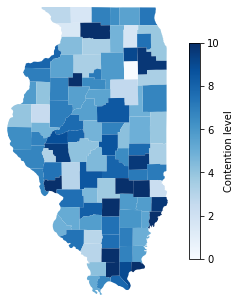

In [71]:
# Plots contention on a map of Illinois

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
color_scale = 'Blues'

ax.axis('off')
ax.margins(0)
vmin, vmax = 0, 10  # Contention is between 0 and 10 
sm = plt.cm.ScalarMappable(cmap=color_scale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.025, label='Contention level')

geo_df.plot(ax=ax, column='contention', cmap=color_scale)
plt.savefig('WindAcceptance.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

## Turbines data

The US wind turbine database [(USWTDB)](https://eerscmap.usgs.gov/uswtdb/) is used to get information on existing wind turbines in Illinois and approximative trends (e.g., number of new projects per year, increases in rotor diameter with time).

In [72]:
turbines_data = pd.read_csv('uswtdb_v4_2_20211101.csv')

# Selects state of Illinois
turbines_data = turbines_data[turbines_data['t_state'] == 'IL'] 

# Extracts information on the number of turbines per wind plant project
min_n_turbines = turbines_data['p_tnum'].min()
max_n_turbines = turbines_data['p_tnum'].max()
mean_n_turbines = turbines_data['p_tnum'].mean()
std_n_turbines = turbines_data['p_tnum'].std()

# Extracts information on turbine rotor diameters and approximative trend
min_t_rd = turbines_data['t_rd'].min()
max_t_rd = turbines_data['t_rd'].max()
mean_t_rd = turbines_data['t_rd'].mean()
std_t_rd = turbines_data['t_rd'].std()
t_rd_mdl_result = st_mdl.ols(formula="t_rd ~ p_year", data=turbines_data).fit().params
int_t_rd_mdl, coef_t_rd_mdl = t_rd_mdl_result['Intercept'], t_rd_mdl_result['p_year']

# Establishes approximative trend regarding the number of new projects per year
project_data = turbines_data.groupby('p_name').mean()
project_data = project_data.sort_values(by=['p_year'])
yearly_project_count = project_data['p_year'].value_counts(sort=False).to_frame()
yearly_project_count = yearly_project_count.sort_index(ascending=True)
yearly_project_count['cum_num_project'] = yearly_project_count['p_year'].cumsum()
yearly_project_count.reset_index(level=0, inplace=True)
p_mdl_result = st_mdl.ols(formula="cum_num_project ~ index", data=yearly_project_count).fit().params
yearly_projects = int(p_mdl_result['index'])

# Start of the model simulation is set to the last year where data is available in the USWTDB
starting_year = turbines_data['p_year'].max()

## Setting up model & agents

The model framework combines agent-based modeling (ABM) with reinforecement learning (Q-learning algorithm). While ABM enables representing the individual decisions of wind plant developers, reinforcement learning provides a means to optimize those decisions. Note that the Q-learning algorithm is applied in a top-down way (i.e., one Q-table rather than agents having individual Q-tables).

### Model

In [73]:
# The model is stochastic, random seed is defined below
seed = 0

# Creates the Q-table with a number of columns (actions) equal to the number of counties 
# (siting choices) and the number of rows (states) equal to the number of simulation steps
column_names = geo_df['County'].unique()
end_year = 2035
states = list(range(0, int(end_year - starting_year), 1))
q_table = pd.DataFrame(0, index=states, columns=column_names)

# Reinforcement learning hyperparameter
epsilon = 0.5

In [74]:
# The Mesa library is used to build the ABM. The model class enables setting the environment of the agents 
# (using the geopanda data frame), activating the agents, and collect simulation outputs.


class WindAcceptanceModel(Model):
    def __init__(self,
                 seed: int = seed,
                 num_agents_init: int = yearly_projects,
                 environment: Type[gpd.GeoDataFrame] = geo_df,
                 q_table: Type[pd.DataFrame] = q_table,
                 states: list = states,
                 learning_rate: float = 0.1,
                 discount: float = 0.95,
                 epsilon: float = epsilon,
                 # source of the 2 lines below is: 
                 # http://solidwize.com/wp-content/uploads/2013/07/7-Understanding-the-Wind-Power-Equation.pdf
                 power_coeff: float = 0.5,
                 air_density: float = 1.225,
                 starting_year: int = int(starting_year),
                 end_year: int = end_year,
                 time_delay: int = 1,
                 penalty: int = 1,
                 reward: int = 1
                ) -> None:
        """
        Initiate model from input data.
        :param seed: number used to initialize the random generator.
        :param num_agents_init: initial number of agents.
        :param environment: environment of the simulation.
        :param q_table: Q-table used in the Q-learning algorithm.
        :param states: states the agents can be in.
        :param learning_rate: Q-learning hyperparameter which determines how fast epsilon decays.
        :param discount: Q-learning hyperparameter which determines how much the agent value reward in future states.
        :param epsilon: Q-learning hyperparameter which determines how often agents take random decisions.
        :param power_coeff: parameter used to compute wind turbines capacity at a location.
        :param air_density: parameter used to compute wind turbines capacity at a location.
        :param starting_year: starting year of the simulation.
        :param end_year: ending year of the simulation.
        :param time_delay: determines how long an agent has to wait if its wind project has been delayed (e.g., due to contention)
        :param penalty: parameter used to adjust the reward function.
        :param reward: parameter used to adjust the reward function.
        """
        # Assigns inputs to instance variables
        self.seed = seed
        self.num_agents_init = num_agents_init
        self.environment = environment.copy()
        self.q_table = q_table
        self.states = states
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.power_coeff = power_coeff
        self.air_density = air_density
        self.starting_year = starting_year
        self.end_year = end_year
        self.time_delay = time_delay
        self.penalty = penalty
        self.reward = reward

        # Initializes random seed
        random.seed(self.seed)
        self.reset_randomizer(self.seed)
        
        # Creates additional instance variables
        self.agent_id = 0
        self.schedule = RandomActivation(self)
        self.min_t_rd = min_t_rd
        self.max_t_rd = max_t_rd
        self.mean_t_rd = mean_t_rd
        self.std_t_rd = std_t_rd
        self.clock = 0
        self.environment['n_turbines_installed'] = 0
        self.environment['crowding'] = 0
        self.environment['cumul_power_generation'] = 0
        self.tot_turbines_installed = dict()
        self.cumul_power_generation = dict()
        self.crowding_level = dict()
        self.hours_in_year = 365.25 * 24  # 365.25 days/year and 24 hours/day
        self.tot_cumul_power_generation = 0
        self.tot_yearly_power_generation = 0
        self.previous_cum_p_gen = 0
        self.max_power_capacity = (
            self.power_coeff * self.air_density * pi * (
            (self.max_t_rd + coef_t_rd_mdl * (self.end_year - self.starting_year)) / 2)**2 * 
            self.environment['wind_speed'].max()**3 / 1E6)  # in MW
        self.contention_delay = 0
        self.total_reward = 0
        self.max_power_generation = self.compute_max_power_generation(
            self.max_t_rd, yearly_projects, max_n_turbines)
        self.power_gen_reward = 0
        self.max_delay = 0
        self.total_installed_cap = 0
        
        # Create initial agents
        self.adding_agents(self.num_agents_init, self.schedule, WindDeveloperAgent)
        
        # Create data collectors
        self.model_reporters = {
            "Clock": "clock",
            "Number of turbines installed": "tot_turbines_installed",
            "Cumulative power generation (TWh)": "cumul_power_generation",
            "Total cumulative power generation (TWh)": "tot_cumul_power_generation", 
            "Delays due to contention (years)": "contention_delay",
            "Total installed capacity": "total_installed_cap",
            "Available land use (%)": "crowding_level"}
        self.data_collector = DataCollector(
            model_reporters=self.model_reporters)
    
    def adding_agents(self, num_agents: int, schedule: Type[RandomActivation], 
                      agent_class: Type[Agent]) -> None:
        """
        Add agents to the schedule.
        :param num_agents: number of agents to add.
        :param schedule: the schedule.
        :param agent_class: the agent class.
        """
        for agent in range(num_agents):
            a = agent_class(self.agent_id, self)
            schedule.add(a)
            self.max_delay += self.time_delay
            self.agent_id += 1
    
    @staticmethod
    def increase_rotor_radius(min_t_rd: float, max_t_rd: float, mean_t_rd: float, 
                              std_t_rd: float, coef_t_rd_mdl: float) -> (float, float, float, float):
        """
        Increase rotor radius according to trend in the USWTDB data.
        :param min_t_rd: minimum value for rotor diameter.
        :param max_t_rd: maximum value for rotor diameterB.
        :param mean_t_rd: mean value for rotor diameter.
        :param std_t_rd: standard deviation value for rotor diameter.
        :param coef_t_rd_mdl: linear regression coefficient for yearly growth in rotor diameter 
        (inferred from the USWTDB).
        :return: new min, max, mean and standard deviation of rotor diameter.
        """
        min_t_rd += coef_t_rd_mdl
        max_t_rd += coef_t_rd_mdl
        mean_t_rd += coef_t_rd_mdl
        std_t_rd += coef_t_rd_mdl
        return min_t_rd, max_t_rd, mean_t_rd, std_t_rd
    
    def compute_max_power_generation(self, max_t_rd: float, yearly_projects: int, 
                                     max_n_turbines: int) -> float:
        """
        Compute the maximum potential power generation for the year.
        :param max_t_rd: maximum value for rotor diameter.
        :param yearly_projects: number of additional project per year (inferred from the USWTDB).
        :param max_n_turbines: maximum number of turbines per wind plant project (inferred from the USWTDB).
        :return: maximum power generation.
        """
        local_wind_speed = self.environment['wind_speed'].max()
        power = (self.power_coeff * self.air_density * pi * (self.max_t_rd / 2)**2 * 
                            local_wind_speed**3) / 1E6
        # Convert MWh to TWh
        max_power_generation = (
            yearly_projects * max_n_turbines * power * self.hours_in_year / 1E6)
        return max_power_generation
    
    def extract_environment_variables(self) -> None:
        """
        Convert panda series to dictionaries and assign them to variables of the Mesa DataCollector object
        (i.e., enables collecting the simulation's outputs).
        """
        self.tot_turbines_installed = self.environment.set_index('County')['n_turbines_installed'].to_dict()
        self.cumul_power_generation = self.environment.set_index('County')['cumul_power_generation'].to_dict()
        self.crowding_level = self.environment.set_index('County')['crowding'].to_dict()
        
    def step(self) -> None:
        """
        Advance the model by one step.
        """
        # Compute cumulative and yearly power generation from newly installed turbines.
        self.tot_cumul_power_generation = self.environment['cumul_power_generation'].sum()
        self.tot_yearly_power_generation = self.tot_cumul_power_generation - self.previous_cum_p_gen
        self.previous_cum_p_gen = self.tot_cumul_power_generation
        # Compute reward for producing wind power.
        self.power_gen_reward = self.tot_cumul_power_generation / self.max_power_generation
        # Activate agents' steps (i.e., behavioral rules)
        self.schedule.step()
        # Update rotor diameter values and maximum power generation.
        self.min_t_rd, self.max_t_rd, self.mean_t_rd, self.std_t_rd = (
            self.increase_rotor_radius(self.min_t_rd, self.max_t_rd, 
                                       self.mean_t_rd, self.std_t_rd, coef_t_rd_mdl))
        self.max_power_generation += self.compute_max_power_generation(
            self.max_t_rd, yearly_projects, max_n_turbines)
        # Collect simulation's outputs
        self.extract_environment_variables()
        self.data_collector.collect(self)
        # Add yearly new wind plant developer and update simulation's clock
        self.adding_agents(yearly_projects, self.schedule, WindDeveloperAgent)
        self.clock += 1

### Agents

In [75]:
# The Mesa library is used to build the ABM. The agent class determine where to site new wind plant projects according
# to values in a Q-table. The Q-learning algorithm uses the Q-table to optimize the trade-off between wind resources
# and contention levels when assigning the siting locations of the new wind plant projects. A simple model is used to 
# constraint siting to where space is available (using the environment defined above).


class WindDeveloperAgent(Agent):
    def __init__(self, unique_id: int, model: Type[Model]) -> None:
        super().__init__(unique_id, model)
        """
        Creation of new agent.
        :param unique_id: unique identifier of the agent.
        :param model: WindAcceptanceModel Mesa model class.
        """
        self.delay = 0
        self.current_state = self.model.clock
        self.siting_status = 'non-sited'
        self.n_turbines = int(trunc_normal_distrib_draw(min_n_turbines, max_n_turbines, 
                                                    mean_n_turbines, std_n_turbines))
        self.t_rd = trunc_normal_distrib_draw(self.model.min_t_rd, self.model.max_t_rd, 
                                              self.model.mean_t_rd, self.model.std_t_rd)
        self.power = 0
        self.site = np.nan
        
    def place_turbines(self) -> None:
        """
        Agents decision process to site new wind turbines.
        """
        if self.delay == 0:
            new_state = min(self.current_state + 1, 
                            (self.model.end_year - self.model.starting_year - 1))
            crowded_counties = self.model.environment[self.model.environment['crowding'] > 1]['County'].tolist()
            q_table_copy = self.model.q_table.copy().drop(crowded_counties, axis = 1)
            if np.random.random() > self.model.epsilon:
                maximums = q_table_copy.idxmax(axis=1)
                action = maximums.loc[self.current_state]
            else:
                action = random.choice(q_table_copy.columns)
            # Contention as a negative reward and risk of delay
            contentions = self.model.environment[self.model.environment['County'] == action]
            # Normalize contention between 0 and 1 (max contention is 10)
            contention = contentions.iloc[0]['contention'] / 10
            if np.random.random() > contention:
                contention_penalty = contention
            else:
                self.delay += self.model.time_delay
                self.siting_status = 'delayed'
                contention_penalty = contention
                self.model.contention_delay += self.model.time_delay
            # If wind plant project is not delayed, add new installed turbines to the environment
            if self.siting_status != 'delayed':
                index_action = self.model.environment.index[self.model.environment['County'] == action]
                self.model.environment.loc[index_action, 'n_turbines_installed'] = (
                    self.model.environment.loc[index_action, 'n_turbines_installed'] + self.n_turbines)
            # Crowding level as a negative reward
            self.model.environment['crowding'] = (
                self.model.environment['n_turbines_installed'] / self.model.environment['max_n_turbine'] * 100) 
            crowding_penalty = (
                self.model.environment[self.model.environment['crowding'] > 1]['crowding'].count() / 
                self.model.environment['crowding'].size)
            # Prepare Q-function inputs
            reward = self.reward_calculation(action, contention_penalty, crowding_penalty)
            current_q = self.model.q_table.loc[self.current_state, action]
            maximums = self.model.q_table.max(axis=1)
            max_future_q = maximums.loc[new_state]
            # Q-function
            new_q = ((1 - self.model.learning_rate) * current_q + self.model.learning_rate * 
                     (reward + self.model.discount * max_future_q))
            self.model.q_table.loc[self.current_state, action] = new_q
            self.current_state = new_state
            if self.siting_status != 'delayed':
                self.site = action
                self.siting_status = 'sited'
        else:
            # If project is delayed, pass to next state (time step)
            self.current_state = min(self.current_state + 1, 
                                     (self.model.end_year - self.model.starting_year - 1))
    
    def reward_calculation(self, action: str, contention_penalty: float, crowding_penalty: float) -> float:
        """
        Compute the reward associated with the action chosen by the agent.
        :param action: action chosen by the agent (i.e., the site of the new wind plant project).
        :param contention_penalty: penalty associated with chosing a site with high contention.
        :param crowding_penalty: penalty associated with chosing a site with a high number of existing turbines.
        :return: reward associated with the action chosen by the agent.
        """
        if self.siting_status != 'delayed':
            # Power generated
            local_wind_speeds = self.model.environment[self.model.environment['County'] == action]
            local_wind_speed = local_wind_speeds.iloc[0]['wind_speed']
            self.power = (self.model.power_coeff * self.model.air_density * pi * (self.t_rd / 2)**2 * 
                            local_wind_speed**3) / 1E6  # in MW
            power_reward = self.power / self.model.max_power_capacity
            # Total power generation reward
            p_gen_reward = self.model.power_gen_reward
            # Local crowding penalty
            index_action = self.model.environment.index[self.model.environment['County'] == action]
            existing_turbines = int(self.model.environment.loc[index_action, 'n_turbines_installed'])
            max_turbines = int(self.model.environment.loc[index_action, 'max_n_turbine'])
            crowding_level = existing_turbines / max_turbines
            local_crowding_penalty = 0
            if crowding_level > 1:
                local_crowding_penalty = self.model.penalty
            # Total crowding penalty
            crowding_penalty += local_crowding_penalty
            # Final reward
            reward = (self.model.reward + power_reward + p_gen_reward - contention_penalty - crowding_penalty)
        else:
            # If wind developper delay siting, a negative reward is returned
            reward = -1 * self.model.penalty - contention_penalty
        # Tracks total reward to evaluate algorithm performance
        self.model.total_reward += reward
        return reward
    
    def update_cumul_power_generation(self) -> None:
        """
        Update total cumulative installed capacity and cumulative power generation. 
        """
        if self.siting_status == 'sited':
            self.model.total_installed_cap += self.power * self.n_turbines
            site = self.model.environment.index[self.model.environment['County'] == self.site]
            # Assumes wind turbines generate power every hour of the year at the average wind speed 
            # and convert MWh to TWh
            self.model.environment.loc[site, 'cumul_power_generation'] += (
                self.power * self.n_turbines * self.model.hours_in_year * (
                    (run.end_year - run.starting_year) - self.model.clock) / 1E6)
    
    def remove_agent(self):
        """
        Remove agent only if turbines are sited.
        """
        if self.siting_status == 'sited':
            self.model.schedule.remove(self)
        else:
            # If agent is delayed, reduces delay by one time step (as agent has been delayed by one time step already)
            self.delay -= self.model.time_delay

    def step(self) -> None:
        """
        Evolution of agent at each step.
        """
        self.place_turbines()
        self.update_cumul_power_generation()
        self.remove_agent()

## Train reinforcement learning algorithm

The Q-learning algorithm is trained and different ouputs are used to assess the performance of the algorithm as function of training episodes. If the "training" variable is set to False, training is skipped and the Q-table in the "q_table.csv" is used in the following steps (to avoid lenghty training computations).

Completion: 0.0% (or 0/2000 episodes) in 6s
Completion: 10.0% (or 200/2000 episodes) in 1098s
Completion: 20.0% (or 400/2000 episodes) in 2353s
Completion: 30.0% (or 600/2000 episodes) in 3250s
Completion: 40.0% (or 800/2000 episodes) in 4142s
Completion: 50.0% (or 1000/2000 episodes) in 4938s
Completion: 60.0% (or 1200/2000 episodes) in 5725s
Completion: 70.0% (or 1400/2000 episodes) in 6523s
Completion: 80.0% (or 1600/2000 episodes) in 7330s
Completion: 90.0% (or 1800/2000 episodes) in 8112s


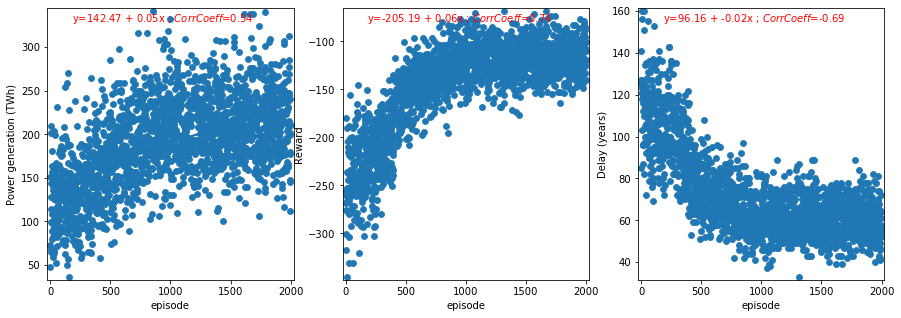

In [76]:
training = True
# Lists used to compute simulation output as a function of training episodes
episode_list = []
energy_output_list = []
reward_output_list = []
delay_output_list = []

# Number of simulations to train the Q-learning algorithm
episodes = 2000
# Q-learning hyperparameters (determines the level of exploration versus exploitation throughout the episodes)
epsilon = 0.5
start_epsilon_decaying = 1
end_epsilon_decaying_factor = 2
end_epsilon_decaying = episodes / end_epsilon_decaying_factor
epsilon_decay_value = epsilon / (end_epsilon_decaying - start_epsilon_decaying)

if training:
    t0 = time.time()
    for episode in range(episodes):
        seed = episode
        # Columns are shuffled to avoid bias when applying min/max to columns with equal values
        # (particularly at the beginning when the Q-table contains many zeros)
        q_table = q_table.T.sample(frac=1).T
        run = WindAcceptanceModel(
            seed=seed,
            q_table=q_table,
            epsilon=epsilon)
        time_steps = run.end_year - run.starting_year  # Period of the simulation
        for time_step in range(time_steps):
            run.step()
        episode_list.append(episode)
        energy_output_list.append(run.tot_cumul_power_generation)
        delay_output_list.append(run.contention_delay)
        reward_output_list.append(run.total_reward)
        if (end_epsilon_decaying >= episode >= start_epsilon_decaying):
            epsilon -= epsilon_decay_value
        t1 = time.time()
        if episode % (ceil(episodes / 10)) == 0:
            print(f'Completion: {episode / episodes * 100}% (or {episode}/{episodes} episodes) in {round(t1 - t0)}s')

    q_table.to_csv('q_table.csv')
    
    num_plot = 0
    variables = [energy_output_list, reward_output_list, delay_output_list]
    titles = ['Power generation (TWh)', 'Reward', 'Delay (years)']
    fig = plt.figure(figsize=(15, 5))
    for variable in variables:
        num_plot += 1
        ax = plt.subplot(1, 3, num_plot)
        ax.margins(0)
        slope, intercept, r_value, p_value, std_err = linregress(episode_list, variable)
        tips = pd.DataFrame(list(zip(episode_list, variable)), columns =['episode', titles[num_plot - 1]])
        sns.scatterplot(data=tips, x="episode", y=titles[num_plot - 1], ax=ax)
        sns.regplot(data=tips, x="episode", y=titles[num_plot - 1], ax=ax)
        ax.text(0.1, 0.95, f'y={round(intercept, 2)} + {round(slope, 2)}x ; $CorrCoeff$={round(r_value, 2)}', 
                transform = ax.transAxes).set_color("red")
    plt.savefig('TrainingResults.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

## Analysis

Once the model is trained, it can be used to identify siting areas optimizing the trade-off between contention levels and wind resources across the US.

### Running the trained model

In [83]:
seed = 0
# Upload Q-table from training
q_table = pd.read_csv('q_table.csv', index_col=0)
replicates = 1
epsilon = 0  # epsilon=0 for optimized decisions (i.e., they should only be based on exploitation (no exploration allowed))
start_epsilon_decaying = 1
end_epsilon_decaying_factor = 2
end_epsilon_decaying = episodes / end_epsilon_decaying_factor
epsilon_decay_value = epsilon / (end_epsilon_decaying - start_epsilon_decaying)
# Collects outputs for analysis
outputs = []

t0 = time.time()
for replicate in range(replicates):
    seed = replicate
    run = WindAcceptanceModel(
        seed=seed,
        q_table=q_table,
        epsilon=epsilon)
    time_steps = run.end_year - run.starting_year  # Period of the simulation
    for time_step in range(time_steps):
        run.step()
    simulation_outputs = run.data_collector.get_model_vars_dataframe()
    outputs.append(simulation_outputs)
    t1 = time.time()
    if replicate % (ceil(replicates / 10)) == 0:
        print(f'Completion: {replicate / replicates * 100}% (or {replicate}/{replicates} replicates) in {round(t1 - t0)}s')

merged_outputs = pd.concat(outputs)
tot_p_gen_n_delay = merged_outputs.groupby(['Clock']).mean()
num_t_installed = merged_outputs.drop(columns=['Total cumulative power generation (TWh)', 
                                       'Cumulative power generation (TWh)', 'Delays due to contention (years)', 
                                               'Total installed capacity', 'Available land use (%)'])
p_generation = merged_outputs.drop(columns=['Total cumulative power generation (TWh)', 
                                       'Number of turbines installed', 'Delays due to contention (years)', 
                                           'Total installed capacity', 'Available land use (%)'])
land_use = merged_outputs.drop(columns=['Total cumulative power generation (TWh)', 
                                       'Number of turbines installed', 'Delays due to contention (years)', 
                                           'Total installed capacity', 'Cumulative power generation (TWh)'])

def extract_data_in_dict(df_in: Type[pd.DataFrame], name_column: str) -> Type[pd.DataFrame]:
    """
    Some data contained in the Mesa data collector object are dictionaries. This function extract the dictionaries' 
    keys and values and build a panda Data Frame from them.
    :param df_in: data frame containing dictionaries in a given column.
    :param name_column: name of the column containing dictionaries.
    """
    intermediate_df = pd.concat([df_in.drop([name_column], axis=1), 
                                 df_in[name_column].apply(pd.Series)], axis=1)
    df_in = (df_in.merge(intermediate_df, on='Clock').drop(
        columns=[name_column]))
    df_out = df_in.melt(
        'Clock', var_name='County', value_name=name_column).groupby(
        ['Clock', 'County']).mean()
    return df_out

num_t_installed = extract_data_in_dict(num_t_installed, 'Number of turbines installed').round()
p_generation = extract_data_in_dict(p_generation, 'Cumulative power generation (TWh)')
land_use = extract_data_in_dict(land_use, 'Available land use (%)')

# Merge all data frames together.
num_t_n_p = num_t_installed.merge(p_generation, on=['Clock', 'County']).reset_index()
num_t_n_p = num_t_n_p.merge(land_use, on=['Clock', 'County']).reset_index()
analysis_df = tot_p_gen_n_delay.merge(num_t_n_p, on='Clock')
analysis_df = analysis_df.merge(geo_df, on='County')
analysis_df = gpd.GeoDataFrame(analysis_df)

Completion: 0.0% (or 0/1 replicates) in 4s


In [84]:
# Data frame for analysis
analysis_df.to_csv('analysis_df.csv')
analysis_df.head()

,Clock,Total cumulative power generation (TWh),Delays due to contention (years),Total installed capacity,index,County,Number of turbines installed,Cumulative power generation (TWh),Available land use (%),TotPopDens,...,FIPS_Cnty,geometry,percent_prod,percent_rep,amenities,illinois,contention,wind_speed,percent_area_avbl,max_n_turbine
0,0,0.000000,1,259.731038,0,Adams,0,0.0,0.0,78.238297,...,17001,"POLYGON ((-90.91046 40.19247, -90.91174 40.104...",18.57869,66.960726,1.987983,True,7.498898,5.848274,0.041572,178
1,1,31.875232,4,464.839889,102,Adams,0,0.0,0.0,78.238297,...,17001,"POLYGON ((-90.91046 40.19247, -90.91174 40.104...",18.57869,66.960726,1.987983,True,7.498898,5.848274,0.041572,178
2,2,55.249026,9,709.965738,204,Adams,0,0.0,0.0,78.238297,...,17001,"POLYGON ((-90.91046 40.19247, -90.91174 40.104...",18.57869,66.960726,1.987983,True,7.498898,5.848274,0.041572,178
3,3,81.034305,14,816.534370,306,Adams,0,0.0,0.0,78.238297,...,17001,"POLYGON ((-90.91046 40.19247, -90.91174 40.104...",18.57869,66.960726,1.987983,True,7.498898,5.848274,0.041572,178
4,4,91.310292,21,904.028858,408,Adams,0,0.0,0.0,78.238297,...,17001,"POLYGON ((-90.91046 40.19247, -90.91174 40.104...",18.57869,66.960726,1.987983,True,7.498898,5.848274,0.041572,178


### Overall 2035 results

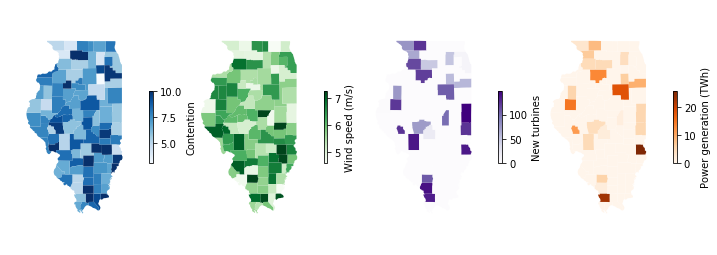

In [109]:
input_df = analysis_df[analysis_df['Clock'] == analysis_df['Clock'].max()] 
num_plot = 0
variables = ['contention', 'wind_speed', 'Number of turbines installed', 'Cumulative power generation (TWh)']
titles = ['Contention', 'Wind speed (m/s)', 'New turbines', 'Power generation (TWh)']
fig = plt.figure(figsize=(12, 12))
for variable in variables:
    num_plot += 1
    ax = plt.subplot(1, 4, num_plot)
    color_scales = ['Blues', 'Greens', 'Purples', 'Oranges']
    ax.axis('off')
    ax.margins(0.2)
    input_df.plot(ax=ax, column=variable, cmap=color_scales[num_plot - 1])
    vmin, vmax = input_df[variable].min(), input_df[variable].max()
    sm = plt.cm.ScalarMappable(cmap=color_scales[num_plot - 1], norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, fraction=0.025, label=titles[num_plot - 1])
plt.savefig('Overall_2035_MapResults.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

### Time series results

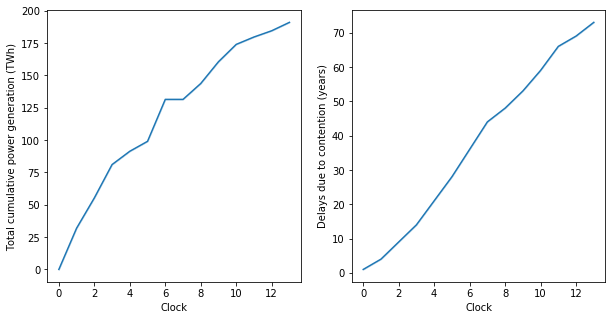

In [90]:
num_plot = 0
variables = ['Total cumulative power generation (TWh)', 'Delays due to contention (years)']
fig = plt.figure(figsize=(10, 5))
for variable in variables:
    num_plot += 1
    ax = plt.subplot(1, 2, num_plot)
    sns.lineplot(ax=ax, data=analysis_df, x="Clock", y=variables[num_plot - 1])
plt.savefig('TimeSeriesResults_Power&Delay.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

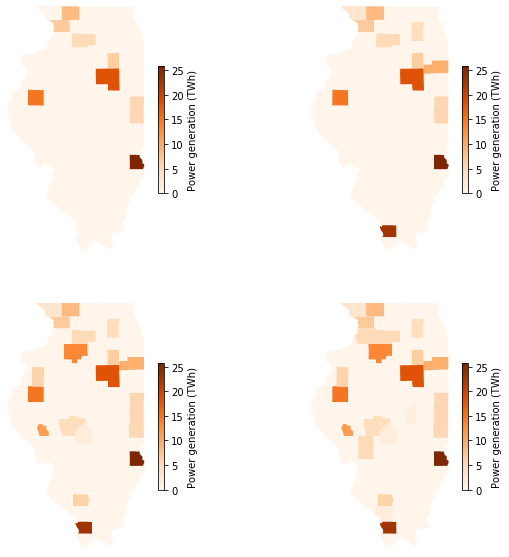

In [91]:
num_plot = 0
periods = [0.25, 0.5, 0.75, 1]
fig = plt.figure(figsize=(10, 10))
for period in periods:
    input_df = analysis_df[analysis_df['Clock'] == round(analysis_df['Clock'].max() * period)]
    num_plot += 1
    ax = plt.subplot(2, 2, num_plot)
    ax.axis('off')
    ax.margins(0)
    vmin, vmax = analysis_df[
        'Cumulative power generation (TWh)'].min(), analysis_df[
        'Cumulative power generation (TWh)'].max()
    input_df.plot(ax=ax, column='Cumulative power generation (TWh)', cmap='Oranges', vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, fraction=0.025, label='Power generation (TWh)')
plt.savefig('TimeSeriesResults_Maps.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

### Other results

In [92]:
# Total production from (assumed to stay constant up to 2035): https://www.eia.gov/state/?sid=IL#tabs-4
# Roughly 10% of electricity is already from wind: https://www.eia.gov/state/analysis.php?sid=IL
production_target = (1 - 0.1) * 14.6  # in TWh
# Yearly production from new turbines
last_step = analysis_df['Clock'].max()
hours_in_year = 365.25 * 24  # 365.25 days/year and 24 hours/day
yearly_prod = (analysis_df[analysis_df['Clock'] == last_step].iloc[0][
    'Total installed capacity'] * hours_in_year / 1E6)  # convert MWh to TWh
target_completion = int(round(yearly_prod / production_target * 100, 0))
print(f'The 100% zero-emission electricity goal by {2022 + last_step} is completed at {target_completion} %')

The 100% zero-emission electricity goal by 2035 is completed at 202 %
